In [10]:
%matplotlib inline

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context('talk')

# Bootstrapping CIs

We want to do a bootstrap estimate of the mean of the exponential distribution from a sample of size 10. 

For this we resample from the sample 10000 times with replacement.

Finally, we estimate the CI using different methods.

In [22]:
distr = sns.distributions.stats.expon()#gamma(a=9)

theta = distr.mean()

def estimator(a, axis=-1):
    return np.mean(a, axis=axis)

n = 10

alpha = .05
upper_perc = 1 - alpha / 2
lower_perc = alpha / 2

In [17]:
def t_interval(resample, estimator, estimate, std=None):
    n = resample.shape[1]
    bootstrap_se = estimator(resample, axis=-1).std(ddof=1)
    return (
        estimate + sns.distributions.stats.t.ppf(
            (lower_perc, upper_perc), df=n-1
        ) * bootstrap_se
    )

def percentile_interval(resample, estimator, estimate=None, std=None):
    return np.quantile(estimator(resample, axis=-1), (lower_perc, upper_perc))

def expanded_percentile_interval(resample, estimator, estimate=None, std=None):
    norm = sns.distributions.stats.norm
    t_distr = sns.distributions.stats.t
    n = resample.shape[-1]
    q_l, q_u = norm.cdf(
        np.sqrt(n / (n - 1)) * t_distr.ppf((lower_perc, upper_perc), df=n-1)
    )
    return np.quantile(
        estimator(resample, axis=-1),
        (q_l, q_u)
    )

def bootstrap_t_table_interval(resample, estimator, estimate, se):
    n = resample.shape[-1]

    # this is only valid if the statistic is the mean!!!!
    # If we try to estimate other statistics, we need the
    # bootstrap SE for each bootstrap sample
    s_star = resample.std(ddof=1, axis=-1) / np.sqrt(n)

    t_star = (estimator(resample) - estimate) / s_star
    
    return estimate - np.quantile(t_star, (upper_perc, lower_perc)) * se

def bca_interval(resample, estimator, sample):
    norm = sns.distributions.stats.norm()
    n = len(sample)
    B = resample.shape[0]
    estimate = estimator(sample)
    replicates = estimator(resample)
    
    z_hat_0 = norm.ppf((replicates < estimate).mean())
    
    # jackknife estimate
    jackknife_mask = ~(np.eye(n).astype(np.bool))
    jk_hat = estimator(
        np.broadcast_to(sample, (n, n))[jackknife_mask]
        .reshape(n, n-1)
    )
    u = (estimate - jk_hat)
    
    a_hat = (
        (u**3).sum()
        / (6 * ((u**2).sum())**(1.5))
    )

    q1 = norm.ppf(lower_perc)
    alpha1 = norm.cdf(
        z_hat_0
        + (z_hat_0 + q1)
        / (1 - a_hat * (z_hat_0 + q1))
    )
    q2 = norm.ppf(upper_perc)
    alpha2 = norm.cdf(
        z_hat_0
        + (z_hat_0 + q2)
        / (1 - a_hat * (z_hat_0 + q2))
    )
#     print(z_hat_0, a_hat, alpha1, alpha2, q1, q2)
    return np.quantile(
        replicates,
        (alpha1, alpha2)
    )

In [18]:
np.random.seed(0)

sample = distr.rvs((1000000, n))
estimator_distribution = estimator(sample)

estimate = estimator_distribution[0]

n_replicates = 10000

resamples = np.random.choice(sample[0], size=(n_replicates, n))

replicates = estimator(resamples)
bootstrap_se = replicates.std(ddof=1)

In [21]:
print(
    "True value: {}; Estimation: {:5.2f};".format(
        theta, estimate
    )
)

t_l, t_u = np.percentile(estimator_distribution, (2.5, 97.5))
print(
    "Estimator distribution: {:5.2f} - {:5.2f} ({:5.2f})".format(
        t_l, t_u, t_u - t_l
    )
)


t_l, t_u = percentile_interval(resamples, estimator)
print(
    "Percentile Interval: {:5.2f} - {:5.2f} ({:5.2f})".format(
        t_l, t_u, t_u - t_l
    )
)

t_l, t_u = t_interval(resamples, estimator, estimate)
print(
    "t interval: {:5.2f} - {:5.2f} ({:5.2f})".format(t_l, t_u, t_u - t_l)
)

t_l, t_u = expanded_percentile_interval(resamples, estimator, estimate)
print(
    "expanded_percentile_interval: {:5.2f} - {:5.2f} ({:5.2f})".format(t_l, t_u, t_u - t_l)
)

t_l, t_u = bootstrap_t_table_interval(resamples, estimator, estimate, bootstrap_se)
print(
    "bootstrap_t_table_interval: {:5.2f} - {:5.2f} ({:5.2f})".format(t_l, t_u, t_u - t_l)
)

t_l, t_u = bca_interval(resamples, estimator, sample[0])
print(
    "bca_interval: {:5.2f} - {:5.2f} ({:5.2f})".format(t_l, t_u, t_u - t_l)
)

True value: 1.0; Estimation:  0.92;
Estimator distribution:  0.81 -  1.20 ( 0.39)
Percentile Interval:  0.74 -  1.11 ( 0.37)
t interval:  0.73 -  1.11 ( 0.38)
expanded_percentile_interval:  0.74 -  1.11 ( 0.38)
bootstrap_t_table_interval:  0.75 -  1.14 ( 0.39)
bca_interval:  0.76 -  1.13 ( 0.38)


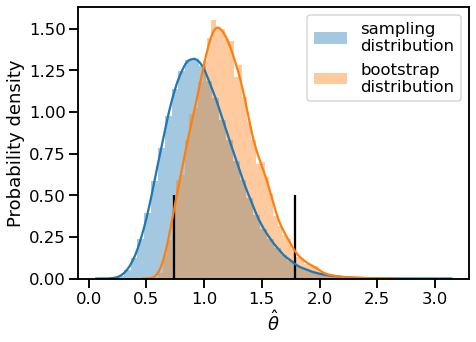

In [6]:
plt.figure(figsize=(7, 5))

sns.distplot(sample_distribution, label="sampling\ndistribution")
sns.distplot(replicates, label="bootstrap\ndistribution")
plt.vlines((0.74, 1.79), 0., 0.5)
plt.legend();
plt.xlabel(r'$\hat{\theta}$');
plt.ylabel('Probability density');
plt.savefig('../img/3_bootstrap_CI.svg', bbox_inches='tight', pad_inches=.1)

Now, instead of having one sample, we create a large set of samples and for each we create the bootstrap confidence intervals. Then we check if the true statistic is within the confidence interval to compute the coverage.

Now we want to investigate the one-sided coverage of the CI methods for different sample sizes

In [7]:
%%time

np.random.seed(0)

n_samples = 10000
sample_sizes = (5, 10, 20, 40, 100, 200, 400)#, 1000)
n_resamples = 10000
methods = (percentile_interval,
           t_interval,
           expanded_percentile_interval,
           bootstrap_t_table_interval,
           bca_interval
          )

coverage = np.zeros(
    (3, len(methods), len(sample_sizes))
)

samples = distr.rvs((n_samples, max(sample_sizes)))

for i_n, n in enumerate(sample_sizes):
    print("Start with {}".format(n))
    for s in samples[:, :n]:
        resamples = np.random.choice(
            s, size=(n_replicates, len(s))
        )
        estimate = estimator(s)
        se_B = estimator(resamples).std(ddof=1)

        for i_m, method in enumerate(methods):
            if method is bca_interval:
                t_l, t_u = method(resamples, estimator, s)
            else:
                t_l, t_u = method(resamples, estimator, estimate, se_B)
            
            coverage[0, i_m, i_n] += int(theta <= t_l)
            coverage[1, i_m, i_n] += int(t_u <= theta)
            coverage[2, i_m, i_n] += 1 - int(t_l < theta < t_u)

coverage /= n_samples

Start with 5


<ipython-input-3-ec3e81115a89>:33: RuntimeWarning: divide by zero encountered in true_divide
  t_star = (estimator(resample) - estimate) / s_star


Start with 10
Start with 20
CPU times: user 3min 1s, sys: 44 ms, total: 3min 1s
Wall time: 3min 1s


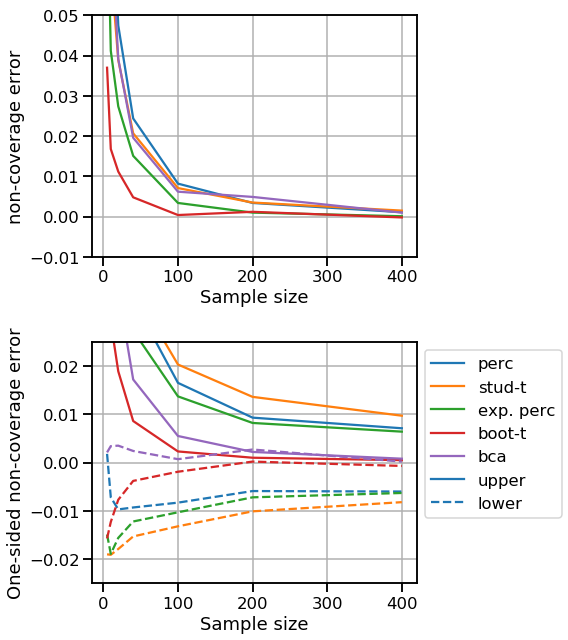

In [8]:
plt.figure(figsize=(8., 9.))

plt.subplot(2, 1, 1)
lines = plt.plot(sample_sizes, coverage[2].T - alpha)
plt.ylim(-.01, .05)
plt.grid()
plt.ylabel("non-coverage error");
plt.xlabel("Sample size");

plt.subplot(2, 1, 2)
plt.plot(sample_sizes, coverage[1].T - 0.025)
plt.gca().set_prop_cycle(None)
lines2 = plt.plot(sample_sizes, coverage[0].T - 0.025, '--')

plt.ylim(-0.025, .025)
plt.legend(
    lines + lines[0:1] + lines2[0:1],
    ('perc', 'stud-t', 'exp. perc', 'boot-t', 'bca', 'upper', 'lower'), bbox_to_anchor=(1., 1.))
plt.grid();
plt.xlabel("Sample size");
plt.ylabel("One-sided non-coverage error");

plt.tight_layout()
plt.savefig('../img/3_bootstrap_CI_coverage_error.svg', bbox_inches='tight', pad_inches=.1)

## Adjustment of the percentiles in the expanded percentile method 

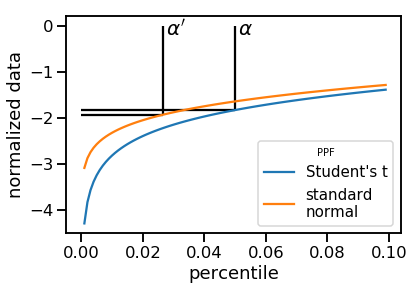

In [14]:
t_distr = sns.distributions.stats.t(df=n-1)
norm_distr = sns.distributions.stats.norm()

n = 10
alpha = 0.05
alpha_prime = norm_distr.cdf(np.sqrt(n / (n - 1)) * t_distr.ppf(alpha))


x = np.arange(0, 0.1, .001)

plt.plot(x, t_distr.ppf(x), label="Student's t")
plt.plot(x, norm_distr.ppf(x), label="standard\nnormal")

plt.vlines(alpha, ymin=0, ymax=t_distr.ppf(alpha))
plt.hlines(xmin=0, xmax=alpha, y=(t_distr.ppf(alpha)))
plt.hlines(xmin=0, xmax=alpha_prime, y=norm_distr.ppf(alpha_prime))
plt.vlines(alpha_prime, ymin=0, ymax=norm_distr.ppf(alpha_prime))

plt.annotate(r'$\alpha$', (alpha+.001, -.2), fontsize=20)
plt.annotate(r'$\alpha^\prime$', (alpha_prime+.001, -.2), fontsize=20)

plt.xlabel('percentile')
plt.ylabel('normalized data')

plt.legend(loc=4, title="PPF", fontsize=15);

plt.savefig('../img/3_bootstrap_CI_exp_prc.svg', bbox_inches='tight', pad_inches=.1)